In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lal import MSUN_SI, C_SI, G_SI

In [2]:
Msun = MSUN_SI * 1e3
C = C_SI * 1e2
G = G_SI * 1e6 / 1e3

## Solve Newtonian Stellar Structure equations

In [3]:
def stellarStructureNewt(r, y, K, rho0):
    m, rho = y
    dmdr = 4 * np.pi * r**2 * rho
    dpdr = - G * m * rho / r**2
    dpdrho = K * abs(rho)**(2/3)*(5 - 4 * (rho0/abs(rho))**(1/3))/3
    drhodr = dpdr/dpdrho
    
    return [dmdr, drhodr]

In [4]:
def hit_surface(r, y, K, rho0):
    return y[1] - rho0

In [5]:
hit_surface.terminal = True

In [6]:
mue = 2
Z = 6
rho0 = 0.4 * Z**2 * mue
K = 1e13 * mue**(-5/3)
rspan = [1e-10, 1e10]
r_eval = np.linspace(rspan[0], rspan[-1], 100000)
y0 = [0, 1e6]

In [7]:
solutionNewt = solve_ivp(stellarStructureNewt, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))

Text(0, 0.5, 'rho [cgs]')

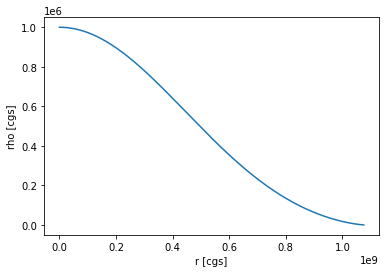

In [8]:
plt.plot(solutionNewt.t, solutionNewt.y[1])
plt.xlabel("r [cgs]")
plt.ylabel("rho [cgs]")

In [9]:
solutionNewt.t_events[0][0]

1075578331.2823124

In [10]:
solutionNewt.y_events[0][0][0]

9.271970906763433e+32

In [11]:
rhocs = 10**np.linspace(6, 9, 20)

In [12]:
RadiiNewt = np.zeros(len(rhocs))
MassesNewt = np.zeros(len(rhocs))
for idx, rhoc in enumerate(rhocs):
    y0 = [0, rhoc]
    solution = solve_ivp(stellarStructureNewt, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
    RadiiNewt[idx] = (solution.t_events[0][0])/1e5
    MassesNewt[idx] = (solution.y_events[0][0][0])/Msun

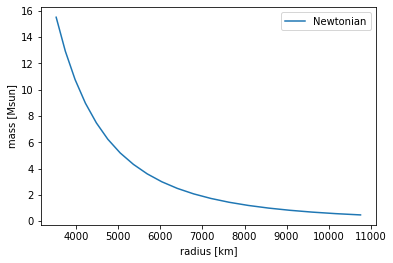

In [13]:
plt.plot(RadiiNewt, MassesNewt, label="Newtonian")
plt.xlabel("radius [km]")
plt.ylabel("mass [Msun]")
plt.legend(loc="upper right")

## Solve TOV

Write down the TOV equations with $G$ and $c$ restored.
$$m\to Gm/c^2$$
$$\rho\to G\rho/c^2$$
$$p\to Gp/c^4$$
So the TOV equations become
$$\frac{dp}{dr} = -\frac{Gm\rho}{r^2}\left[1 + \frac{1}{c^2}\frac{p}{\rho}\right]\left[1 + \frac{1}{c^2}\frac{4\pi r^3 p}{m}\right]\left[1 - \frac{2Gm}{c^2r}\right]^{-1}$$

In [14]:
def tov(r, y, K, rho0):
    m, rho = y
    p = K * abs(rho)**(5/3) * (1 - (rho0/abs(rho))**(1/3))
    dmdr = 4 * np.pi * r**2 * rho
    dpdr = - (G * m * rho / r**2) * (1 + (p/(C**2 * rho))) * (1 + (4*np.pi*r**3*p/(C**2*m))) * (1 - (2*G*m/(C**2*r)))**(-1)
    dpdrho = K * ((5/3) * abs(rho)**(2/3) * (1 - (rho0/abs(rho))**(1/3)) + abs(rho)**(5/3)*(rho0**(1/3)*(1/3)*abs(rho)**(-4/3)))
    drhodr = dpdr/dpdrho
    
    return [dmdr, drhodr]

In [15]:
y0 = [1e-10, 1e11]
solutionTOV = solve_ivp(tov, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
solutionNewt = solve_ivp(stellarStructureNewt, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))

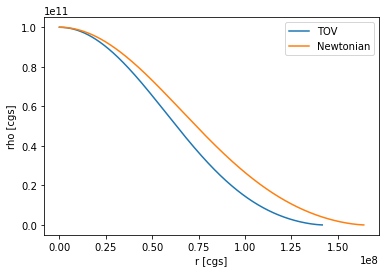

In [16]:
plt.plot(solutionTOV.t, solutionTOV.y[1], label="TOV")
plt.plot(solutionNewt.t, solutionNewt.y[1], label="Newtonian")
plt.xlabel("r [cgs]")
plt.ylabel("rho [cgs]")
plt.legend(loc="upper right")

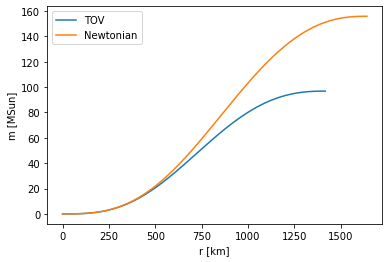

In [17]:
plt.plot(solutionTOV.t/1e5, solutionTOV.y[0]/Msun, label="TOV")
plt.plot(solutionNewt.t/1e5, solutionNewt.y[0]/Msun, label="Newtonian")
plt.xlabel("r [km]")
plt.ylabel("m [MSun]")
plt.legend(loc="upper left")

In [18]:
RadiiTOV = np.zeros(len(rhocs))
MassesTOV = np.zeros(len(rhocs))
for idx, rhoc in enumerate(rhocs):
    y0 = [1e-10, rhoc]
    solutionTOV = solve_ivp(tov, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
    RadiiTOV[idx] = (solutionTOV.t_events[0][0])/1e5
    MassesTOV[idx] = (solutionTOV.y_events[0][0][0])/Msun

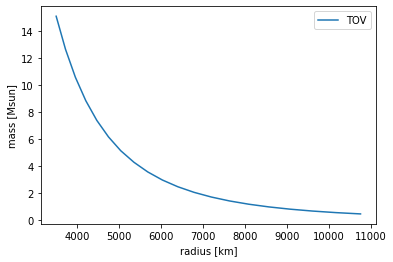

In [19]:
plt.plot(RadiiTOV, MassesTOV, label="TOV")
plt.xlabel("radius [km]")
plt.ylabel("mass [Msun]")
plt.legend(loc="upper right")

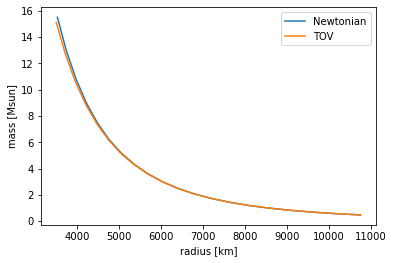

In [20]:
plt.plot(RadiiNewt, MassesNewt, label="Newtonian")
plt.plot(RadiiTOV, MassesTOV, label="TOV")
plt.xlabel("radius [km]")
plt.ylabel("mass [Msun]")
plt.legend(loc="upper right")

In [21]:
rhocsNS = 10**(np.linspace(13, 16, 50))
RadiiTOVNS = np.zeros(len(rhocsNS))
MassesTOVNS = np.zeros(len(rhocsNS))
for idx, rhoc in enumerate(rhocsNS):
    y0 = [1e-10, rhoc]
    solutionTOVNS = solve_ivp(tov, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
    RadiiTOVNS[idx] = (solutionTOVNS.t_events[0][0])/1e5
    MassesTOVNS[idx] = (solutionTOVNS.y_events[0][0][0])/Msun

In [22]:
rhocsNS = 10**(np.linspace(13, 16, 50))
RadiiNewtNS = np.zeros(len(rhocsNS))
MassesNewtNS = np.zeros(len(rhocsNS))
for idx, rhoc in enumerate(rhocsNS):
    y0 = [1e-10, rhoc]
    solutionNewtNS = solve_ivp(stellarStructureNewt, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
    RadiiNewtNS[idx] = (solutionNewtNS.t_events[0][0])/1e5
    MassesNewtNS[idx] = (solutionNewtNS.y_events[0][0][0])/Msun

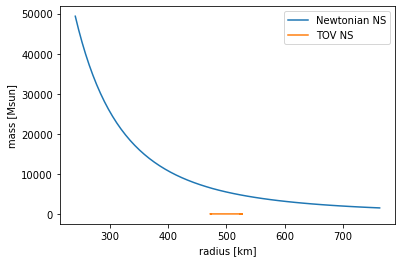

In [23]:
plt.plot(RadiiNewtNS, MassesNewtNS, label="Newtonian NS")
plt.plot(RadiiTOVNS, MassesTOVNS, label="TOV NS")
plt.xlabel("radius [km]")
plt.ylabel("mass [Msun]")
plt.legend(loc="upper right")

In [24]:
RadiiTOVNS

array([473.91224794, 472.28864341, 471.88857001, 472.69474679,
       474.60205591, 476.91998935, 480.37926257, 484.4098247 ,
       488.58697227, 492.25965042, 496.44227162, 500.81080105,
       504.6084154 , 507.42077998, 510.71958564, 513.69344677,
       516.12729927, 517.99761883, 519.4813847 , 521.03047037,
       521.69602557, 523.12615358, 523.09029898, 524.01829532,
       524.84345925, 524.58250217, 525.17825299, 525.89869893,
       525.30135678, 525.86366314, 526.30327604, 525.66223613,
       526.12186894, 526.37460268, 525.83979656, 526.35650489,
       525.8622063 , 526.23301669, 526.59473268, 525.84308562,
       526.28613509, 526.48667925, 525.94416549, 526.41491436,
       526.48687688, 525.91427157, 526.26141   , 526.48492511,
       525.9846117 , 526.44405808])

In [25]:
MassesTOVNS

array([71.84143066, 70.46367051, 69.23326634, 68.16897415, 67.2759517 ,
       66.51503882, 65.93086715, 65.48624849, 65.15883352, 64.89186703,
       64.74517254, 64.69755318, 64.68620221, 64.66961922, 64.73805967,
       64.82836017, 64.91751933, 65.00665584, 65.08699495, 65.18632641,
       65.23808665, 65.34165533, 65.36307219, 65.43906414, 65.51012234,
       65.51842491, 65.57212608, 65.63331768, 65.61652359, 65.6626134 ,
       65.70467096, 65.67767854, 65.7128081 , 65.74191796, 65.71340664,
       65.74763409, 65.72285047, 65.75003742, 65.77723631, 65.73493002,
       65.76221417, 65.78245161, 65.74777318, 65.7750441 , 65.78592561,
       65.74984336, 65.76923963, 65.78911405, 65.75558101, 65.78150878])

## TOV polytropic vs SLy

In [26]:
rhoSly, pSly = np.loadtxt("sly4.dat", usecols=(2,3), unpack=True)

In [27]:
from scipy.interpolate import interp1d

logrho_interp = interp1d(np.log(pSly), np.log(rhoSly), kind="cubic", fill_value="extrapolate")  # since the order varies a lot we interpolate in logspace
logp_interp = interp1d(np.log(rhoSly), np.log(pSly), kind="cubic", fill_value="extrpolate")
def p_interp(rho):
    return np.exp(logp_interp(np.log(abs(rho))))
def rho_interp(p):
    return np.exp(logrho_interp(np.log(abs(p))))

In [28]:
def tovSly(r, y):
    m, p = y
    rho = rho_interp(p)
    dmdr = 4 * np.pi * r**2 * rho
    dpdr = - (G * m * rho / r**2) * (1 + (p/(C**2 * rho))) * (1 + (4*np.pi*r**3*p/(C**2*m))) * (1 - (2*G*m/(C**2*r)))**(-1)
    
    return [dmdr, dpdr]

In [29]:
def hit_surface_p(r, y):
    return  y[1]

In [30]:
hit_surface_p.terminal = True

In [31]:
y0sly = [1e-10, p_interp(5e15)]
y0 = [1e-10, 1e15]
solutionTOV = solve_ivp(tov, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
solutionNewt = solve_ivp(stellarStructureNewt, rspan, y0, t_eval=r_eval, events=hit_surface, args=(K, rho0))
solutionTOVNSSly = solve_ivp(tovSly, rspan, y0sly, t_eval=r_eval, events=hit_surface_p)

(0.0, 10000000.0)

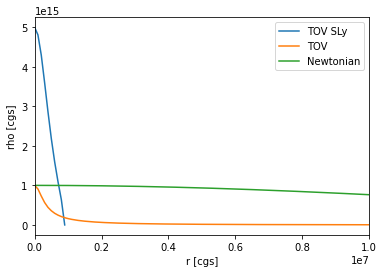

In [32]:
plt.plot(solutionTOVNSSly.t, rho_interp(solutionTOVNSSly.y[1]), label="TOV SLy")
plt.plot(solutionTOV.t, solutionTOV.y[1], label="TOV")
plt.plot(solutionNewt.t, solutionNewt.y[1], label="Newtonian")
plt.xlabel("r [cgs]")
plt.ylabel("rho [cgs]")
plt.legend(loc="upper right")
plt.xlim(0, 1e7)

(0.0, 2.0)

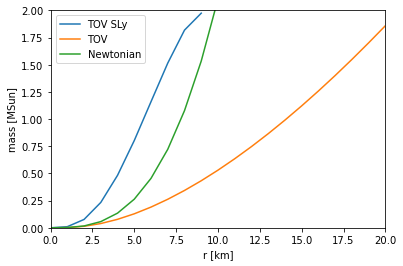

In [33]:
plt.plot(solutionTOVNSSly.t/1e5, solutionTOVNSSly.y[0]/Msun, label="TOV SLy")
plt.plot(solutionTOV.t/1e5, solutionTOV.y[0]/Msun, label="TOV")
plt.plot(solutionNewt.t/1e5, solutionNewt.y[0]/Msun, label="Newtonian")
plt.xlabel("r [km]")
plt.ylabel("mass [MSun]")
plt.legend(loc="upper left")
plt.xlim(0, 20)
plt.ylim(0, 2)